<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/lvm/dcgan_fashion_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep convolutional generative adversarial networks (DCGAN)

This tutorial fits a DC-GAN to Fashion-MNIST. The code is based on
https://www.tensorflow.org/beta/tutorials/generative/dcgan


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.9.2'

In [5]:
!pip install imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.0 MB/s eta 0:00:00a 0:00:01


In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [7]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
#train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images = train_images / 255 # Normalize the images to [0,1]
train_images = (train_images * 2) -1 # Normalize the images to [-1, 1]


In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # assumes output is [-1,1]
    #model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid')) # assumes output is [0,1]
    assert model.output_shape == (None, 28, 28, 1)

    return model
  



Use the (as yet untrained) generator to create an image.

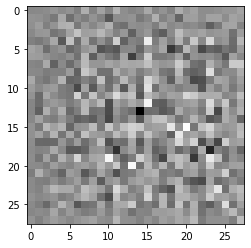

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='binary')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    #model.add(layers.Dense(1, activation="sigmoid")) # cross-entropy loss assumes logits as input

    return model
  

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00179927]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # don't need sigmoid on output of discriminator

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [18]:
#generator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.RMSprop()
discriminator_optimizer = tf.keras.optimizers.RMSprop()


### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop



In [20]:
noise_dim = 100
num_examples_to_generate = 25 # 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
#http://www.datawrangling.org/python-montage-code-for-displaying-arrays/
  
from numpy import array,flipud,shape,zeros,rot90,ceil,floor,sqrt
from scipy import io,reshape,size
import pylab
 
def montage(X, colormap=pylab.cm.gist_gray):    
    m, n, count = shape(X)    
    mm = int(ceil(sqrt(count)))
    nn = mm
    M = zeros((mm * m, nn * n))

    image_id = 0
    for j in range(mm):
        for k in range(nn):
            if image_id >= count: 
                break
            sliceM, sliceN = j * m, k * n
            M[sliceN:sliceN + n, sliceM:sliceM + m] = X[:, :, image_id]
            image_id += 1
                    
    pylab.imshow(flipud(rot90(M)), cmap=colormap)
    pylab.axis('off')             

# We assume tensor is [N, H, W, 1].
def plot_montage(tensor):
    tensor = tensor[:, :, :, 0]
    X = np.transpose(tensor, [2, 1, 0])
    montage(X)
  

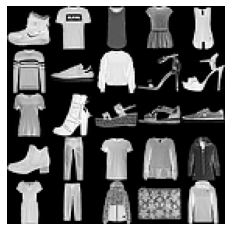

In [22]:
tensor = train_images[:25, :, :]
plot_montage(tensor)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  predictions = (predictions + 1)/2 # map back to [0,1]
  plot_montage(predictions)
  plt.tight_layout()
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

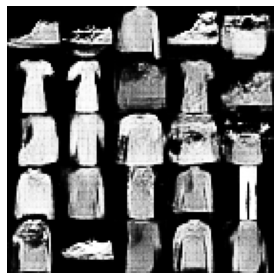

CPU times: user 2h 1min 42s, sys: 12min 37s, total: 2h 14min 19s
Wall time: 22min 27s


In [26]:
%%time
EPOCHS = 10
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
!ls

README.md               image_at_epoch_0003.png image_at_epoch_0007.png
dcgan_fashion_tf.ipynb  image_at_epoch_0004.png image_at_epoch_0008.png
image_at_epoch_0001.png image_at_epoch_0005.png image_at_epoch_0009.png
image_at_epoch_0002.png image_at_epoch_0006.png image_at_epoch_0010.png


## Create a GIF


In [29]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [30]:
# Remove border from image
#  https://gist.github.com/kylemcdonald/bedcc053db0e7843ef95c531957cb90f
def full_frame(width=None, height=None):
    import matplotlib as mpl
    mpl.rcParams['savefig.pad_inches'] = 0
    figsize = None if width is None else (width, height)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    

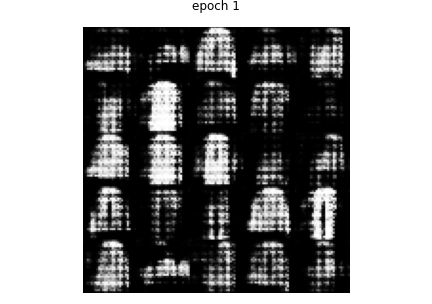

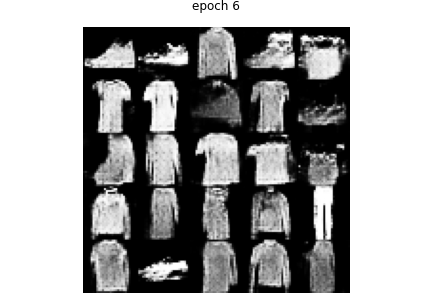

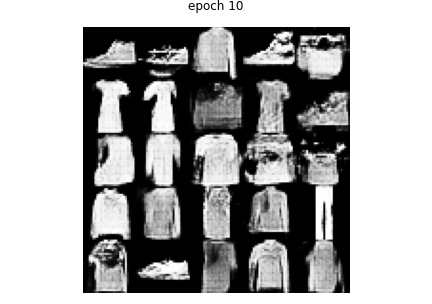

In [31]:
step = 5
ndx = list(range(1, EPOCHS, step))
ndx.append(EPOCHS)
for i in ndx:
  img = display_image(i)
  full_frame()
  plt.imshow(img)
  plt.axis('off')
  ttl = 'epoch {}'.format(i)
  plt.title(ttl)
  plt.show()